In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input,decode_predictions
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
!pip install natsort

from natsort import natsorted
from PIL import Image

In [ ]:
InputPath1='/content/drive/MyDrive/Denoising/train/high'
InputPath2='/content/drive/MyDrive/Denoising/train/low'
InputPath3='/content/drive/MyDrive/Denoising/validation/high'
InputPath4='/content/drive/MyDrive/Denoising/validation/low'

255

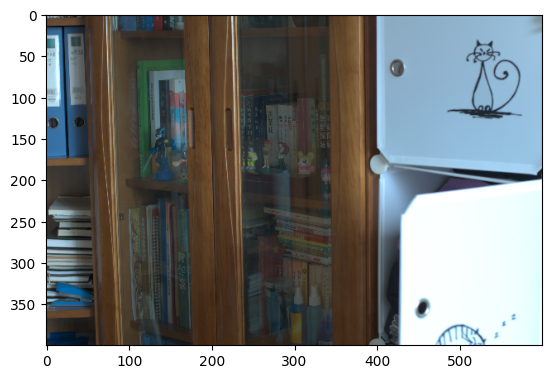

In [ ]:
filename = '2.png'
img = cv.imread(os.path.join(InputPath1, filename))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.imshow(img)
l

In [ ]:
 file_names = [f for f in os.listdir(InputPath2) if f.endswith('.png')]

# Step 4: Sort the file names alphabetically
sorted_file_names = sorted(file_names)
train_low_light = []
for file_name in sorted_file_names:
    file_path = os.path.join(InputPath2, file_name)
    img = Image.open(file_path)
    img_array = np.array(img)
    train_low_light.append(img_array)

In [ ]:
 file_names = [f for f in os.listdir(InputPath1) if f.endswith('.png')]

# Step 4: Sort the file names alphabetically
sorted_file_names = sorted(file_names)
train_enhanced = []
for file_name in sorted_file_names:
    file_path = os.path.join(InputPath1, file_name)
    img = Image.open(file_path)
    img_array = np.array(img)
    train_enhanced.append(img_array)

In [ ]:
 file_names = [f for f in os.listdir(InputPath3) if f.endswith('.png')]

# Step 4: Sort the file names alphabetically
sorted_file_names = sorted(file_names)
val_enhanced  = []
for file_name in sorted_file_names:
    file_path = os.path.join(InputPath3, file_name)
    img = Image.open(file_path)
    img_array = np.array(img)
    val_enhanced .append(img_array)

In [ ]:
 file_names = [f for f in os.listdir(InputPath4) if f.endswith('.png')]

# Step 4: Sort the file names alphabetically
sorted_file_names = sorted(file_names)
val_low_light  = []
for file_name in sorted_file_names:
    file_path = os.path.join(InputPath4, file_name)
    img = Image.open(file_path)
    img_array = np.array(img)
    val_low_light .append(img_array)

In [ ]:
 val_low_light = np.array(val_low_light)
 val_enhanced = np.array(val_enhanced)
 train_low_light = np.array(train_low_light)
 train_enhanced = np.array(train_enhanced)

In [ ]:
# Normalize the images
train_low_light = train_low_light / 255.0
val_low_light = val_low_light / 255.0
train_enhanced = train_enhanced / 255.0
val_enhanced = val_enhanced / 255.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Input

def build_enhancement_model(input_shape):
    inputs = Input(shape=input_shape)

    # First convolutional layer
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Intermediate layers
    for _ in range(5):
        x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    # Last convolutional layer
    outputs = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the input shape (e.g., 128x128 RGB images)
input_shape = (train_low_light.shape[1], train_low_light.shape[2], train_low_light.shape[3])
model = build_enhancement_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 600, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 600, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 400, 600, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 400, 600, 64)      36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 400, 600, 64)      36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 400, 600, 64)      36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 400, 600, 64)      36928 

In [ ]:
# Train the model
model.fit(
    train_low_light, train_enhanced,
    validation_data=(val_low_light, val_enhanced),
    epochs=50,
    batch_size=16
)


In [ ]:
import tensorflow as tf

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Predict on the validation set
val_predictions = model.predict(val_low_light)

# Calculate PSNR
psnr_values = psnr(val_enhanced, val_predictions)
print(f"Average PSNR: {np.mean(psnr_values)} dB")